In [ ]:
#! -*- coding: utf-8 -*-

## 1. PyCBCチュートリアル：バイナリマージャーやLIGO / Virgo Open Dataのカタログへのアクセス

コンパクトバイナリマージャーによる天体物理源の発見と重力波データの研究、それらのパラメータの研究に使用される[PyCBC](http://github.com/ligo-cbc/pycbc)ライブラリを使用します。 これらは、LIGOとVirgoの協力がLIGO / Virgoデータの重力波を見つけるために使用するのと同じツールです

このチュートリアルでは、バイナリマージャーのカタログに関する情報をプログラムを使って取得する方法と、各イベントの周りの検出器の歪みデータを読み込む方法、またはLIGOの最初の観測のためにリリースされた完全な公開データセットから読み込む方法について説明します。

他の[例](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) とモジュールのドキュメントは[ここ](http://pycbc.org/pycbc/latest/html/py-modindex.html)

#### カタログにはどのようなバイナリマージャーがありますか？ ####

In [1]:
from pycbc import catalog

### List the mergers in the catalog
for merger_name in catalog.Catalog():
    print(merger_name)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


LVT151012
GW170608
GW150914
GW170814
GW170817
GW170104
GW151226


#### どのようにパラメータを取得できますか？ ####

各ソースの基本パラメータの一部を取得することもできます
次のようにカタログから直接入手してください。 すべてのパラメータが与えられていることに注意してください
*ソース*フレーム内にあります。 これは、赤方偏移の影響を含んでいることを意味します。

In [2]:
# Either from the catalog as a whole
c = catalog.Catalog()
mchirp = c.median1d('mchirp')
print(mchirp)

# or from a specific merger
m = catalog.Merger("GW170817")
mchirp_gw170817 = m.median1d('mchirp')
print('GW170817: {}'.format(mchirp_gw170817))

# print parameters that can be read
print (m.data['median1d'].keys())

[ 15.1     7.9    28.1    24.1     1.188  21.1     8.9  ]
GW170817: 1.188
['mchirp', 'mtotal', 'mass1', 'redshift', 'mass2', 'chi_eff']


#### マスパラメータを検出器フレームに変換する

デフォルトでは、上記のインタフェースは* source *フレーム内のパラメータを返します。 宇宙論的な赤方偏移のために、重力波は移動すると伸びます。 これにより、検出された波形は検出器フレームにおいて異なるものとなる。 これは、質量パラメータの観測された変化（例えば）に対応する。 しかし、その関係はかなり簡単です。

In [3]:
m = catalog.Merger('GW150914')
source_mtotal = m.median1d('mtotal')
redshift = m.median1d('redshift')
det_mtotal = source_mtotal * (1 + redshift)

print('Total Mass of GW150914')
print('Source Frame: {} Solar Masses'.format(source_mtotal))
print('Detector Frame: {} Solar Masses'.format(det_mtotal))

Total Mass of GW150914
Source Frame: 65.3 Solar Masses
Detector Frame: 71.177 Solar Masses


### 1.2 LIGO / Virgoデータへのアクセス

このセクションでは、PyCBC APIを使用してLIGOおよびVirgo計測器から検出器データを読み取る方法について説明します。 S5 / S6 / O1 LIGO観測をカバーするリリースされた完全なデータセットから特定のイベントの周りのデータを取得することも可能です。 データは[pycbc TimeSeries objects.](http://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries)として返されます。

#### カタログ内の特定のバイナリ合併に関するデータの取得

特定の事象の周りのデータを直接取り出すことができます。 通常、このデータはイベントを中心にしていますが、これを許可していない制限が適用される場合があります。 このメソッドは、デフォルトでデータセットの最小バージョンを取得します。 追加のデータまたは特定のバージョンが必要な場合は、データにアクセスする次の2つの追加の方法を参照してください。

Duration: 32.0s Start: 1126259446 End: 1126259478


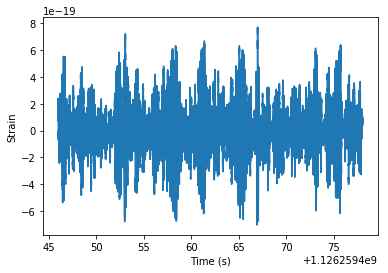

In [4]:
%matplotlib inline

import pylab

m = catalog.Merger("GW150914")

# Get the time series data around GW150914 from Hanford
# 'ts_han' is a pycbc.types.TimeSeries object which contains
# gravitational-wave strain in this instance and has metadata
# such as the start time, and sample rate.
ts_han = m.strain('H1')

# And now livingston
ts_liv = m.strain('L1')

# We can see how much data was returned and its boundaries
# Note: All times are given in seconds since the GPS time epoch
print("Duration: {}s Start: {} End: {}".format(ts_han.duration, 
                                              int(ts_han.start_time),
                                              int(ts_han.end_time)))

# We can directly plot the time series as follows
pylab.plot(ts_han.sample_times, ts_han)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

#### S5 / S6 / O1からのデータの取得

このセクションでは、LIGOによるバルクデータリリースからデータを読み込む方法を示します。 これは現在、S5、S6、およびO1分析の期間をカバーしています。

In [5]:
from pycbc.frame import query_and_read_frame

# Retrieve the approximate time of the merger
m = catalog.Merger("GW150914")
start = m.time - 32
end = m.time + 32
# start = int(m.time) - 5
# end = int(m.time) + 5
# print (m.time)
# print (dir(m))
# Get 64 seconds of data roughly around GW150914
# The start / end time may be any in the publicly available data sets.
ts = query_and_read_frame('LOSC', 'H1:LOSC-STRAIN', start, end)

# If we wanted to retreive data from the Livingston detector
# we'd use the following command instead
# ts = query_and_read_frame('LOSC', 'L1:LOSC-STRAIN', start, end)

print("Returned {}s of data at {}Hz".format(ts.duration, ts.sample_rate))

Returned 64.0s of data at 4096Hz


#### 重力波フレームファイルを直接読み込む

自分のコンピュータにLIGOデータを保存すると、次のようにデータを直接読み込むことができます。

In [6]:
# We'll first download some data for this demonstration
!curl -O -J https://losc.ligo.org/s/events/LVT151012/H-H1_LOSC_4_V2-1128678884-32.gwf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1004k  100 1004k    0     0   704k      0  0:00:01  0:00:01 --:--:--  704k


In [9]:
from pycbc.frame import read_frame

# Read the data directly from the Gravitational-Wave Frame (GWF) file.
file_name = "H-H1_LOSC_4_V2-1128678884-32.gwf"

# LOSC bulk data typically uses the same convention for internal channels names
# Strain is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1.
channel_name = "H1:LOSC-STRAIN"

start = 1128678884
end = start + 32

ts = read_frame(file_name, channel_name, start, end)

print ts

[ -1.58962885e-19  -1.65536724e-19  -1.57538591e-19 ...,   2.32756613e-20
   9.88382550e-21   4.53929579e-21]
